In [625]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [626]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import random
import torch

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
print(os.listdir("../content/drive/My Drive/plates"))


# Any results you write to the current directory are saved as output.

['test', 'train']


In [627]:
!ls '../content/drive/My Drive/plates'

test  train


In [628]:
data_root = '/content/drive/My Drive/plates/'
print(os.listdir(data_root))

['test', 'train']


In [629]:
import shutil 
from tqdm import tqdm
'''
train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))'''

"\ntrain_dir = 'train'\nval_dir = 'val'\n\nclass_names = ['cleaned', 'dirty']\n\nfor dir_name in [train_dir, val_dir]:\n    for class_name in class_names:\n        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)\n\nfor class_name in class_names:\n    source_dir = os.path.join(data_root, 'train', class_name)\n    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):\n        if i % 6 != 0:\n            dest_dir = os.path.join(train_dir, class_name) \n        else:\n            dest_dir = os.path.join(val_dir, class_name)\n        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))"

In [630]:
!ls /content/drive/My Drive/plates/train

ls: cannot access '/content/drive/My': No such file or directory
ls: cannot access 'Drive/plates/train': No such file or directory


In [0]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.CenterCrop(224),
    transforms.ColorJitter(0.6, 0.5, 0.5, (-0.5,0.1)),
    #transforms.RandomVerticalFlip(),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.ColorJitter(1.0, 0.3, 0.3, 0.5),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder('../content/drive/My Drive/plates/train', train_transforms)


batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)


In [632]:
len(train_dataloader), len(train_dataset)

(5, 40)

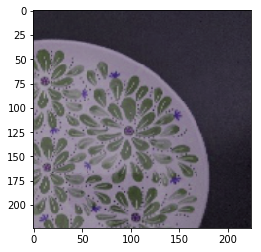

In [633]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

In [634]:
'''def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])'''

"def show_input(input_tensor, title=''):\n    image = input_tensor.permute(1, 2, 0).numpy()\n    image = std * image + mean\n    plt.imshow(image.clip(0, 1))\n    plt.title(title)\n    plt.show()\n    plt.pause(0.001)\n\nX_batch, y_batch = next(iter(train_dataloader))\n\nfor x_item, y_item in zip(X_batch, y_batch):\n    show_input(x_item, title=class_names[y_item])"

In [0]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        
        dataloader = train_dataloader
        scheduler.step()
        model.train()  # Set model to training mode
              # Set model to evaluate mode

        running_loss = 0.
        running_acc = 0.

            # Iterate over data.
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # forward and backward
            with torch.set_grad_enabled(True):
                preds = model(inputs)
                loss_value = loss(preds, labels)
                preds_class = preds.argmax(dim=1)

                # backward + optimize only if in training phase

                loss_value.backward()
                optimizer.step()

            # statistics
            running_loss += loss_value.item()
            running_acc += (preds_class == labels.data).float().mean()

        epoch_loss = running_loss / len(dataloader)
        epoch_acc = running_acc / len(dataloader)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format('TRAIN', epoch_loss, epoch_acc), flush=True)

    return model

In [0]:
model = models.resnet18(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1.0e-3, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=11, gamma=0.1)

In [637]:
train_model(model, loss, optimizer, scheduler, num_epochs=75);

Epoch 0/74:


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 5/5 [00:00<00:00,  5.13it/s]


TRAIN Loss: 0.7816 Acc: 0.3000
Epoch 1/74:


100%|██████████| 5/5 [00:00<00:00,  5.12it/s]

TRAIN Loss: 0.7180 Acc: 0.5500
Epoch 2/74:



100%|██████████| 5/5 [00:00<00:00,  5.07it/s]

TRAIN Loss: 0.6942 Acc: 0.5750
Epoch 3/74:



100%|██████████| 5/5 [00:00<00:00,  5.14it/s]

TRAIN Loss: 0.6309 Acc: 0.6250
Epoch 4/74:



100%|██████████| 5/5 [00:00<00:00,  3.01it/s]

TRAIN Loss: 0.5705 Acc: 0.6500
Epoch 5/74:



100%|██████████| 5/5 [00:00<00:00,  5.45it/s]

TRAIN Loss: 0.5335 Acc: 0.7250
Epoch 6/74:



100%|██████████| 5/5 [00:00<00:00,  1.96it/s]

TRAIN Loss: 0.4361 Acc: 0.8750
Epoch 7/74:



100%|██████████| 5/5 [00:00<00:00,  3.34it/s]

TRAIN Loss: 0.5267 Acc: 0.7750
Epoch 8/74:



100%|██████████| 5/5 [00:00<00:00,  1.93it/s]

TRAIN Loss: 0.5098 Acc: 0.7500
Epoch 9/74:



100%|██████████| 5/5 [00:00<00:00,  1.97it/s]

TRAIN Loss: 0.3818 Acc: 0.9250
Epoch 10/74:



100%|██████████| 5/5 [00:00<00:00,  1.94it/s]

TRAIN Loss: 0.4450 Acc: 0.8000
Epoch 11/74:



100%|██████████| 5/5 [00:00<00:00,  5.17it/s]

TRAIN Loss: 0.3614 Acc: 0.9000
Epoch 12/74:



100%|██████████| 5/5 [00:00<00:00,  5.31it/s]

TRAIN Loss: 0.3994 Acc: 0.8750
Epoch 13/74:



100%|██████████| 5/5 [00:00<00:00,  2.00it/s]

TRAIN Loss: 0.4281 Acc: 0.8750
Epoch 14/74:



100%|██████████| 5/5 [00:00<00:00,  1.95it/s]

TRAIN Loss: 0.4275 Acc: 0.8500
Epoch 15/74:



100%|██████████| 5/5 [00:00<00:00,  5.32it/s]

TRAIN Loss: 0.4255 Acc: 0.8500
Epoch 16/74:



100%|██████████| 5/5 [00:00<00:00,  1.99it/s]

TRAIN Loss: 0.3560 Acc: 0.8500
Epoch 17/74:



100%|██████████| 5/5 [00:00<00:00,  5.31it/s]

TRAIN Loss: 0.3498 Acc: 0.9000
Epoch 18/74:



100%|██████████| 5/5 [00:00<00:00,  2.02it/s]

TRAIN Loss: 0.3340 Acc: 0.8750
Epoch 19/74:



100%|██████████| 5/5 [00:00<00:00,  1.94it/s]

TRAIN Loss: 0.4089 Acc: 0.8250
Epoch 20/74:



100%|██████████| 5/5 [00:00<00:00,  1.92it/s]

TRAIN Loss: 0.3917 Acc: 0.9000
Epoch 21/74:



100%|██████████| 5/5 [00:00<00:00,  2.01it/s]

TRAIN Loss: 0.4757 Acc: 0.7500
Epoch 22/74:



100%|██████████| 5/5 [00:00<00:00,  1.93it/s]

TRAIN Loss: 0.3834 Acc: 0.8750
Epoch 23/74:



100%|██████████| 5/5 [00:00<00:00,  1.98it/s]

TRAIN Loss: 0.4545 Acc: 0.8000
Epoch 24/74:



100%|██████████| 5/5 [00:00<00:00,  1.91it/s]

TRAIN Loss: 0.3555 Acc: 0.9250
Epoch 25/74:



100%|██████████| 5/5 [00:00<00:00,  5.15it/s]

TRAIN Loss: 0.4235 Acc: 0.8500
Epoch 26/74:



100%|██████████| 5/5 [00:00<00:00,  1.95it/s]

TRAIN Loss: 0.3519 Acc: 0.8500
Epoch 27/74:



100%|██████████| 5/5 [00:00<00:00,  1.95it/s]

TRAIN Loss: 0.3811 Acc: 0.8500
Epoch 28/74:



100%|██████████| 5/5 [00:00<00:00,  5.20it/s]

TRAIN Loss: 0.3388 Acc: 0.9000
Epoch 29/74:



100%|██████████| 5/5 [00:00<00:00,  1.93it/s]

TRAIN Loss: 0.4665 Acc: 0.7250
Epoch 30/74:



100%|██████████| 5/5 [00:00<00:00,  5.13it/s]

TRAIN Loss: 0.3674 Acc: 0.9250
Epoch 31/74:



100%|██████████| 5/5 [00:00<00:00,  5.40it/s]

TRAIN Loss: 0.4643 Acc: 0.7500
Epoch 32/74:



100%|██████████| 5/5 [00:00<00:00,  5.35it/s]

TRAIN Loss: 0.4032 Acc: 0.9250
Epoch 33/74:



100%|██████████| 5/5 [00:00<00:00,  5.30it/s]

TRAIN Loss: 0.4251 Acc: 0.8250
Epoch 34/74:



100%|██████████| 5/5 [00:00<00:00,  5.36it/s]

TRAIN Loss: 0.3956 Acc: 0.8500
Epoch 35/74:



100%|██████████| 5/5 [00:00<00:00,  5.22it/s]

TRAIN Loss: 0.4121 Acc: 0.8000
Epoch 36/74:



100%|██████████| 5/5 [00:00<00:00,  1.94it/s]

TRAIN Loss: 0.3668 Acc: 0.9000
Epoch 37/74:



100%|██████████| 5/5 [00:00<00:00,  1.93it/s]

TRAIN Loss: 0.5213 Acc: 0.7250
Epoch 38/74:



100%|██████████| 5/5 [00:00<00:00,  5.25it/s]

TRAIN Loss: 0.4500 Acc: 0.7750
Epoch 39/74:



100%|██████████| 5/5 [00:00<00:00,  1.95it/s]

TRAIN Loss: 0.3803 Acc: 0.9000
Epoch 40/74:



100%|██████████| 5/5 [00:00<00:00,  1.83it/s]

TRAIN Loss: 0.4674 Acc: 0.7500
Epoch 41/74:



100%|██████████| 5/5 [00:00<00:00,  1.85it/s]

TRAIN Loss: 0.4632 Acc: 0.7750
Epoch 42/74:



100%|██████████| 5/5 [00:00<00:00,  1.91it/s]

TRAIN Loss: 0.4302 Acc: 0.8250
Epoch 43/74:



100%|██████████| 5/5 [00:00<00:00,  5.00it/s]

TRAIN Loss: 0.3948 Acc: 0.8500
Epoch 44/74:



100%|██████████| 5/5 [00:00<00:00,  1.92it/s]

TRAIN Loss: 0.4331 Acc: 0.8250
Epoch 45/74:



100%|██████████| 5/5 [00:00<00:00,  5.06it/s]

TRAIN Loss: 0.4365 Acc: 0.8250
Epoch 46/74:



100%|██████████| 5/5 [00:00<00:00,  1.87it/s]

TRAIN Loss: 0.4011 Acc: 0.8500
Epoch 47/74:



100%|██████████| 5/5 [00:00<00:00,  5.08it/s]

TRAIN Loss: 0.4316 Acc: 0.7500
Epoch 48/74:



100%|██████████| 5/5 [00:00<00:00,  1.91it/s]

TRAIN Loss: 0.4914 Acc: 0.8000
Epoch 49/74:



100%|██████████| 5/5 [00:00<00:00,  1.89it/s]

TRAIN Loss: 0.3828 Acc: 0.8750
Epoch 50/74:



100%|██████████| 5/5 [00:00<00:00,  5.14it/s]

TRAIN Loss: 0.4426 Acc: 0.7750
Epoch 51/74:



100%|██████████| 5/5 [00:00<00:00,  1.91it/s]

TRAIN Loss: 0.4209 Acc: 0.8000
Epoch 52/74:



100%|██████████| 5/5 [00:00<00:00,  1.87it/s]

TRAIN Loss: 0.4054 Acc: 0.8250
Epoch 53/74:



100%|██████████| 5/5 [00:00<00:00,  1.92it/s]

TRAIN Loss: 0.3963 Acc: 0.8250
Epoch 54/74:



100%|██████████| 5/5 [00:00<00:00,  5.14it/s]

TRAIN Loss: 0.3401 Acc: 0.9000
Epoch 55/74:



100%|██████████| 5/5 [00:00<00:00,  5.16it/s]

TRAIN Loss: 0.4429 Acc: 0.8000
Epoch 56/74:



100%|██████████| 5/5 [00:00<00:00,  1.87it/s]

TRAIN Loss: 0.4451 Acc: 0.8250
Epoch 57/74:



100%|██████████| 5/5 [00:00<00:00,  1.91it/s]

TRAIN Loss: 0.4018 Acc: 0.8250
Epoch 58/74:



100%|██████████| 5/5 [00:00<00:00,  5.12it/s]

TRAIN Loss: 0.4336 Acc: 0.8000
Epoch 59/74:



100%|██████████| 5/5 [00:00<00:00,  1.88it/s]

TRAIN Loss: 0.3783 Acc: 0.8750
Epoch 60/74:



100%|██████████| 5/5 [00:00<00:00,  1.86it/s]

TRAIN Loss: 0.3713 Acc: 0.8750
Epoch 61/74:



100%|██████████| 5/5 [00:00<00:00,  1.86it/s]

TRAIN Loss: 0.3272 Acc: 0.9000
Epoch 62/74:



100%|██████████| 5/5 [00:00<00:00,  1.84it/s]

TRAIN Loss: 0.4199 Acc: 0.8500
Epoch 63/74:



100%|██████████| 5/5 [00:00<00:00,  1.94it/s]

TRAIN Loss: 0.4017 Acc: 0.8250
Epoch 64/74:



100%|██████████| 5/5 [00:00<00:00,  5.05it/s]

TRAIN Loss: 0.3447 Acc: 0.9000
Epoch 65/74:



100%|██████████| 5/5 [00:00<00:00,  1.84it/s]

TRAIN Loss: 0.4557 Acc: 0.8250
Epoch 66/74:



100%|██████████| 5/5 [00:00<00:00,  5.21it/s]

TRAIN Loss: 0.3447 Acc: 0.8500
Epoch 67/74:



100%|██████████| 5/5 [00:00<00:00,  5.15it/s]

TRAIN Loss: 0.3890 Acc: 0.8500
Epoch 68/74:



100%|██████████| 5/5 [00:00<00:00,  1.86it/s]

TRAIN Loss: 0.4765 Acc: 0.7750
Epoch 69/74:



100%|██████████| 5/5 [00:00<00:00,  1.84it/s]

TRAIN Loss: 0.3618 Acc: 0.9000
Epoch 70/74:



100%|██████████| 5/5 [00:00<00:00,  1.89it/s]

TRAIN Loss: 0.3258 Acc: 0.9000
Epoch 71/74:



100%|██████████| 5/5 [00:00<00:00,  1.90it/s]

TRAIN Loss: 0.4231 Acc: 0.8000
Epoch 72/74:



100%|██████████| 5/5 [00:00<00:00,  5.36it/s]

TRAIN Loss: 0.3754 Acc: 0.9000
Epoch 73/74:



100%|██████████| 5/5 [00:00<00:00,  1.94it/s]

TRAIN Loss: 0.4966 Acc: 0.8500
Epoch 74/74:



100%|██████████| 5/5 [00:00<00:00,  5.23it/s]

TRAIN Loss: 0.3556 Acc: 0.8250


In [638]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [0]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths(test_dir, val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [640]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [00:04<00:00, 18.85it/s]


In [641]:
'''inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)'''

'inputs, labels, paths = next(iter(test_dataloader))\n\nfor img, pred in zip(inputs, test_predictions):\n    show_input(img, title=pred)'

In [0]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [643]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.65 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

,label
id,
0000,dirty
0001,dirty
0002,cleaned
0003,dirty
0004,dirty
0005,dirty


In [0]:
#submission_df.to_csv('submission.csv')

In [0]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ssub.csv', index_col=0)
data = data.set_index(['id'])
data['label'][743]= 'cleaned'

In [0]:
m=0
for i in range(744):
  if data['label'][i]==submission_df['label'][i]:
    m+=1

In [647]:
print(m/744) 

0.9139784946236559


In [0]:
!rm -rf train val test